# Temas relevantes

In [1]:
import mysql.connector as mariadb
import sys

try:
    conn = mariadb.connect(
      user="root",
      password="root",
      host="127.0.0.1",
      port=3306
      )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)
cursor=conn.cursor()
cursor.execute("USE %s"%"noticias")


Obtengo el cursor que me permite ejecutar comandos SQL en mi computadora

In [2]:
def get_corpus(seleccion= ["noticia"], fecha="fecha"):
    seleccion=seleccion+[fecha]
    cursor.execute("SELECT %s FROM notas WHERE fecha = %s"%tuple(seleccion))
    
    resultados=cursor.fetchall()
    return resultados
    

Declaro el campo que quiero obtener. Actualmente está pensado para obtener un campo a la vez. Puedo obtener los datos de alguna fecha en particular de todas.

In [3]:
corpus=get_corpus(["noticia"],"fecha")

In [4]:
len(corpus)

2506

## Procesamiento de lenguaje

In [5]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import spacy


from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import matplotlib.colors as mcolors
from collections import Counter


Obtenemos las stopwords de NLP y el Stemmer para pasar las palabras a su raíz

In [6]:
stemmer = SnowballStemmer('spanish')
nlp = spacy.load('es_core_news_sm')

Con esta función notmalizo el texto a sus palabras más "fundamentales"

In [7]:
def normalizar(texto):
    doc = nlp(texto)
    palabras = [t.orth_ for t in doc if not (t.is_punct | t.is_stop) and t.pos_ != 'PRON']
    tokens = [t.lower() for t in palabras if len(t) > 3 and t.isalpha()]
    raices = [stemmer.stem(token) for token in tokens]
    return raices

In [8]:
word_list = normalizar("Esto es lo que uno debería esperar después de que se pre-procesa un texto")

In [9]:
word_list

['deb', 'esper', 'text']

Con esta función modifico las noticias para que tengan sólo las palabras semánticamente relevantes y en su forma raíz.

In [10]:
def modificar_corpus(corpus):
    corpus_modificado=[]
    for noticia in corpus:
        corpus_modificado.append(normalizar(noticia[0]))
    return corpus_modificado
    

CM = Corpus Modificado

In [11]:
CM=modificar_corpus(corpus)

## Aprendizaje No Supervisado

Aquí me pongo a ver los temas más importantes con la herramienta más popular que encontré: LDA.

In [12]:
import gensim
from gensim import models
import gensim.corpora as corpora

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from gensim.models import LdaModel, CoherenceModel

In [13]:
dictionary=corpora.Dictionary(CM)

In [14]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)


In [15]:
bow_corpus = [dictionary.doc2bow(noticia) for noticia in CM]

In [16]:
num_of_topics=20

In [17]:
num_topics = list(range(num_of_topics+1)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    #generamos modelo con i temas
    LDA_models[i] = gensim.models.LdaMulticore(bow_corpus, num_topics=i, id2word=dictionary, 
                                       passes=10, workers=2,
                                      random_state=1,per_word_topics=True)

    #obtenemos los temas por cada modelo
    shown_topics = LDA_models[i].show_topics(num_topics=i, num_words=num_keywords, formatted=False)
    
    #encontramos las palabras de cada tema
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

Encuentro qué tanto me beneficia agregar otro tema. Si me beneficia mucho esperaría que fueran menos similares los conjuntos de palabras. Por eso uso la similaridad de Jaccard. 

In [18]:
def jaccard_similarity(topic_1, topic_2):
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))

    return len(intersection)/len(union)

In [19]:
LDA_stability = {}
#miramos a la similitud entre los temas al usar x o x+1 agrupamientos
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): 
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]):
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims

mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [20]:
#Hallamos la coherencia de cada modelo tentativo
coherences = [CoherenceModel(model=LDA_models[i], texts=CM, dictionary=dictionary, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [32]:
#encontramos el número de temas para el que la coherencia
#es más grande que la similitud.
#le agregué el -(i*0.01) para que tuviera preferencia por menor cantidad de temas
coh_sta_diffs = [(coherences[i] - mean_stabilities[i])-(i*0.01) for i in range(num_keywords)[:-1]] 
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]

#entoncramos el numero ideal de temas de esta manera
ideal_topic_num_index = coh_sta_max_idxs[0]
ideal_topic_num = num_topics[ideal_topic_num_index]

In [33]:
ideal_topic_num

8

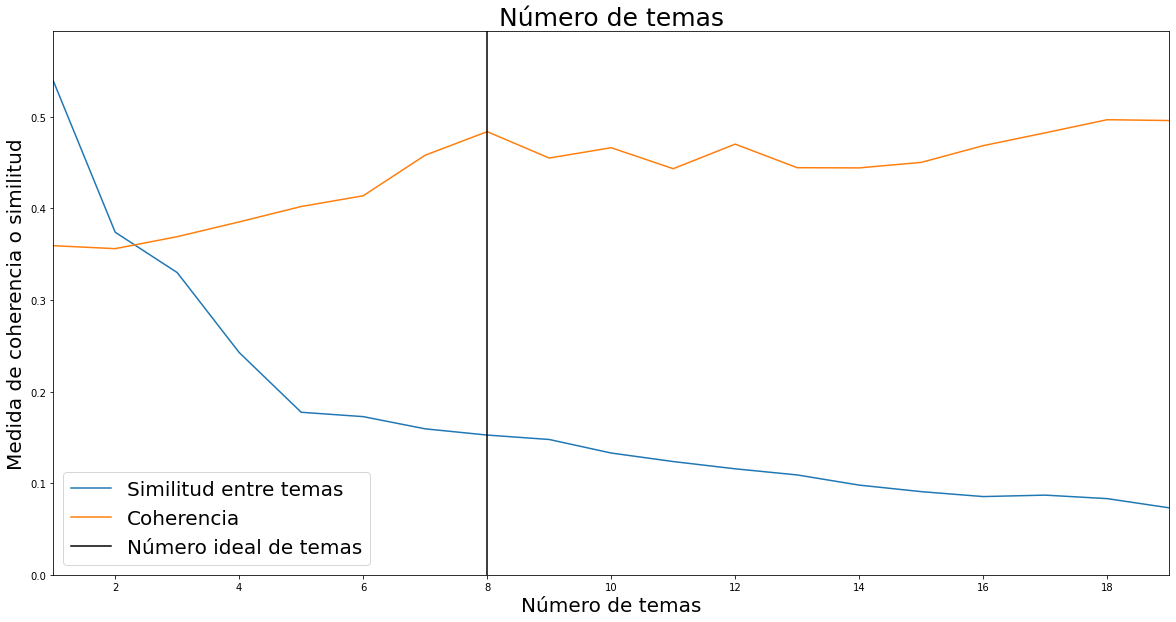

In [34]:

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Similitud entre temas')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Coherencia')

ax.axvline(x=ideal_topic_num, label='Número ideal de temas', color='black')
#ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Número de temas', fontsize=25)
ax.set_ylabel('Medida de coherencia o similitud', fontsize=20)
ax.set_xlabel('Número de temas', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

Lo mejor es encontrar el punto donde la distancia entre estas dos líneas es máxima, pero como no queremos ejegir muchos temas, penalizamos el número de temas elegidos

In [35]:
num_of_topics=8

In [36]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_of_topics, id2word=dictionary, 
                                       passes=13, workers=2,
                                      random_state=1,per_word_topics=True)

## Resultados

In [37]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from matplotlib.patches import Rectangle

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


import seaborn as sns
import matplotlib.colors as mcolors

In [38]:
def get_topic_DF(ldamodel, corpus, bow_texts,original,num_of_topics):

    topic_df = pd.DataFrame()
    
    #extraemos las palabras clave por tema en un diccionario
    topic_keywords={}
    for topic_num in range(num_of_topics):
        wp = ldamodel.show_topic(topic_num) #vector de tuplas de la forma (palabra, contribucion)
        topic_keywords[topic_num] = ", ".join([word for word, prob in wp])
    
    
    #para cada documento sacamos su tema dominante, su probabilidad y las palabras clave del tema
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        dominant=row[0]
        topic_num=dominant[0]
        prob_topic=dominant[1]
        
        topic_df = topic_df.append(pd.Series([int(topic_num), round(prob_topic,4), topic_keywords[topic_num]]), ignore_index=True)

    
    #añadimos los textos originales al DF
    contents = pd.Series(bow_texts)
    original = pd.Series(original)

    topic_df = pd.concat([topic_df, contents,original], axis=1)
    topic_df.columns = ['Tema Principal', 'Contribucion', 'Palabras Clave','Texto Normalizado', 'Texto Original']

    return(topic_df)


topic_df = get_topic_DF(lda_model, bow_corpus,CM,corpus,num_of_topics)

topic_df.head(10)


,Tema Principal,Contribucion,Palabras Clave,Texto Normalizado,Texto Original
0,5.0,0.9959,"fot, public, leer, instagram, compart, cas, añ...","[luch, libr, adopt, deport, favorit, mexican, ...",(La lucha libre ha sido adoptada como uno de l...
1,5.0,0.9889,"fot, public, leer, instagram, compart, cas, añ...","[lleg, teatr, virtual, edicion, artist, incogn...",(Llega al teatro virtual la segunda edición de...
2,1.0,0.4600,"cient, pes, millon, mexic, empres, econom, pan...","[pequeñ, destil, ginebr, whisky, proveedor, re...",(Muchas pequeñas destilerías de ginebra y whis...
3,2.0,0.6387,"part, tigr, equip, club, lig, jugador, mexican...","[gignac, gener, polem, particip, mundial, club...",(André-Pierre Gignac generó polémica en estos ...
4,5.0,0.6517,"fot, public, leer, instagram, compart, cas, añ...","[format, reality, musical, mexic, import, expo...",(Desde que el formato del reality musical lleg...
5,5.0,0.4276,"fot, public, leer, instagram, compart, cas, añ...","[sigl, public, gatsby, novel, estadounidens, p...","(Casi un siglo después de su publicación, ""El ..."
6,5.0,0.5266,"fot, public, leer, instagram, compart, cas, añ...","[cantant, lupit, castr, acus, vicent, fernande...","(La cantante Lupita Castro, quien acusa a Vice..."
7,4.0,0.3826,"person, cas, usuari, inform, polic, años, segu...","[cient, person, fallec, mexic, testament, mile...",(El 94 por ciento de las personas que han fall...
8,5.0,0.7749,"fot, public, leer, instagram, compart, cas, añ...","[acus, abus, sexual, marilyn, manson, actriz, ...",(Tras las acusaciones de abusos sexuales contr...
9,2.0,0.5508,"part, tigr, equip, club, lig, jugador, mexican...","[ray, visit, ray, necax, duel, correspondient,...",(Los Rayados visitaron a los Rayos del Necaxa ...


In [39]:
# Display setting to show more characters in column
def get_most_representative(topic_df,num_of_topics):
    pd.options.display.max_colwidth = 150

    representative_DF = pd.DataFrame()
    topics_grouping = topic_df.groupby('Tema Principal')

    for i, grp in topics_grouping:
        representative_DF = pd.concat([representative_DF,grp.sort_values(['Contribucion'], ascending=False).head(1)], 
                                axis=0)
    return representative_DF
    
representative_DF=get_most_representative(topic_df,num_of_topics)
representative_DF

,Tema Principal,Contribucion,Palabras Clave,Texto Normalizado,Texto Original
517,0.0,0.9966,"mujer, niñ, libr, estudi, nacional, educ, mexic, investig, vid, person","[frent, clim, extrem, situacion, actual, pandemi, padec, mund, result, fundamental, proteg, resfri, grip, indispens, ayud, sistem, inmun, encarg, ...","(Frente a los climas extremos y la situación actual de pandemia que padece el mundo, resulta fundamental protegerse de resfriados y gripes. Para h..."
320,1.0,0.9969,"cient, pes, millon, mexic, empres, econom, pandemi, pais, servici, merc","[banc, unid, presion, reserv, federal, ampli, concesion, flexibiliz, requisit, capital, produj, pandemi, argument, merc, financier, estaran, riesg...",(Los bancos de Estados Unidos presionan a la Reserva Federal para que amplíe las concesiones que flexibilizaron los requisitos de capital cuando s...
2205,2.0,0.9966,"part, tigr, equip, club, lig, jugador, mexican, mundial, futbol, años","[años, tigr, consolid, proyect, lig, man, ricard, ferretti, regres, conjunt, regiomontan, conquist, titul, lig, final, concachampions, campeon, ca...","(En los últimos 10 años, Tigres se consolidó como el mejor proyecto de la Liga MX. De la mano de Ricardo Ferretti, quien regresó en 2010, el conju..."
1394,3.0,0.9973,"president, trump, polit, gobiern, part, diput, federal, proces, moren, public","[part, polit, decid, unirs, bloqu, gan, mayor, escañ, cam, diput, gubernatur, jueg, import, fuer, rival, ener, consej, institut, nacional, elector...",(Seis partidos políticos han decidido unirse en dos bloques con un mismo fin: ganar la mayoría de los escaños en la Cámara de Diputados y las 15 g...
649,4.0,0.9970,"person, cas, usuari, inform, polic, años, segur, public, investig, social","[whatsapp, aplic, mensaj, instantane, popular, exit, med, funcion, ofrec, usuari, aplic, permit, llam, videollam, envi, fot, vide, stickers, gifs,...","(WhatsApp es una de las aplicaciones de mensajería instantánea más populares del momento. Su éxito se debe, en gran medida, a las diferentes funci..."
1029,5.0,0.9970,"fot, public, leer, instagram, compart, cas, años, amor, pas, mexic","[necesari, lleg, febrer, celebr, amor, parej, propon, experient, romant, ciud, mexic, compart, person, favorit, seman, epoc, picnics, tip, locacio...",(No es necesario que llegue el 14 de febrero para celebrar el amor en pareja. Para ello te proponemos estas experiencias románticas cerca de Ciuda...
1245,6.0,0.9973,"vacun, pais, unid, person, millon, cas, dosis, salud, lleg, recib","[mision, expert, chin, encontr, prueb, contundent, orig, pandemi, dej, millon, muert, mund, alt, improb, virus, fug, laboratori, wuh, logr, identi...","(La misión de expertos de la OMS en China no encontró pruebas contundentes sobre el origen de la pandemia de Covid-19, que ha dejado 2.3 millones ..."
1427,7.0,0.9973,"vacun, salud, municipi, cas, person, mexic, mayor, gobiern, adult, oaxac","[doming, lleg, cargament, vacun, virus, leon, lot, vacun, virus, traid, doming, leon, aeronav, fuerz, aere, mexican, inici, vacun, masiv, adult, m...",(Este domingo llegaron nuevos cargamentos con vacunas contra el virus SARS-CoV-2.\n\nNuevo León\nUn lote de 36 mil 410 vacunas contra el virus SAR...


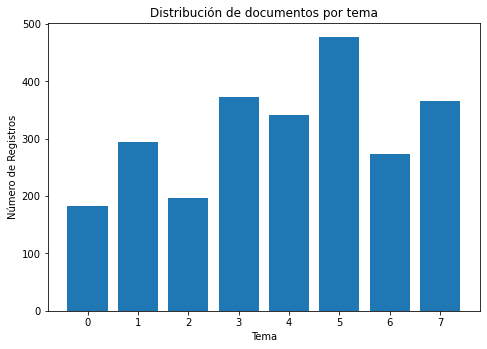

In [60]:
x=[]
y=[]
for i in range(8):
    c=topic_df.loc[topic_df["Tema Principal"] == i]
    x.append(len(c))
    y.append(i)
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(y,x)
ax.set_ylabel("Número de Registros")
ax.set_xlabel("Tema")
ax.set_title("Distribución de documentos por tema")
plt.show()


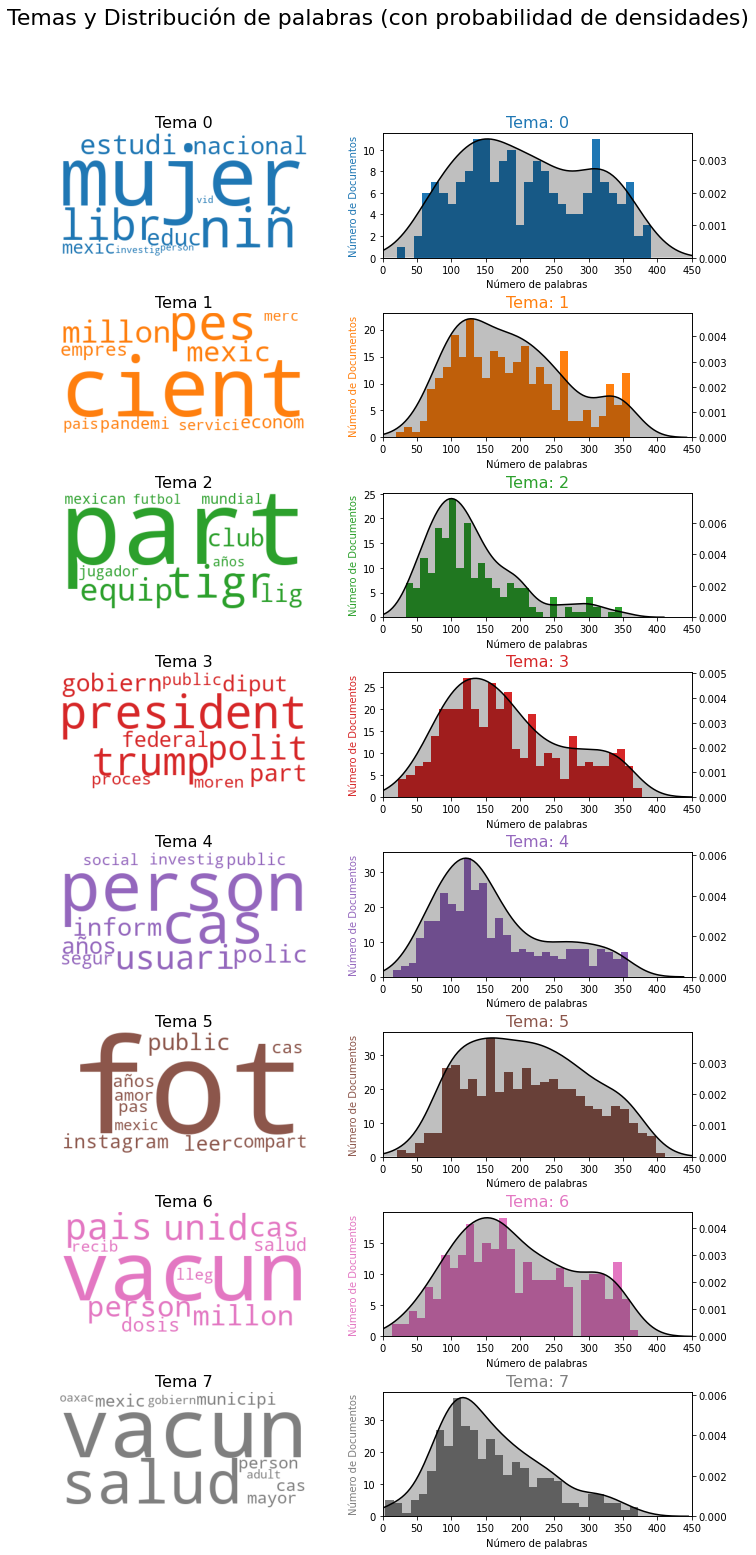

In [41]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] if num_of_topics < 10 else [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stopwords.words('spanish'),
                  background_color='white',
                  
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=num_of_topics,formatted=False)


fig, axes = plt.subplots(nrows=num_of_topics, ncols=2, figsize=(10,int((num_of_topics+1)*2.5)))



#para las X
lower_limit=0
upper_limit=450
#cuantas barras para el histograma
bins=30


#Para los plots

for j, ax in enumerate(axes.flatten()):
    i=j//2
    if j%2: 
        df_dominant_topic_sub = topic_df.loc[topic_df["Tema Principal"] == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub["Texto Normalizado"]]
        
        ax.hist(doc_lens, bins = bins, color=cols[i])
        
        sns.kdeplot(doc_lens, color="black", shade=True, ax=ax.twinx())
        
        ax.set(xlim=(lower_limit, upper_limit), xlabel='Número de palabras')
        ax.set_ylabel('Número de Documentos', color=cols[i])
        ax.set_title('Tema: '+str(i), fontdict=dict(size=16, color=cols[i]))
    else:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Tema ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
        
        
        
fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Temas y Distribución de palabras (con probabilidad de densidades)', fontsize=22)
plt.show()

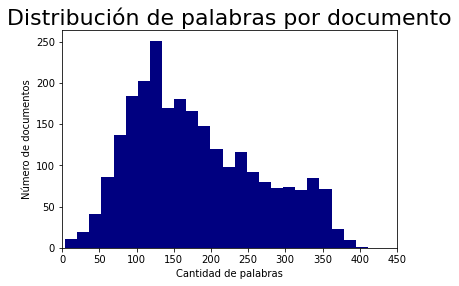

In [40]:
doc_lens = [len(d) for d in topic_df["Texto Normalizado"]]

plt.hist(doc_lens, bins = 25, color='navy')

limite_inferior=0
limite_superior=450

plt.gca().set(xlim=(limite_inferior, limite_superior), ylabel="Número de documentos", xlabel="Cantidad de palabras")
plt.title("Distribución de palabras por documento", fontdict=dict(size=22))
plt.show()

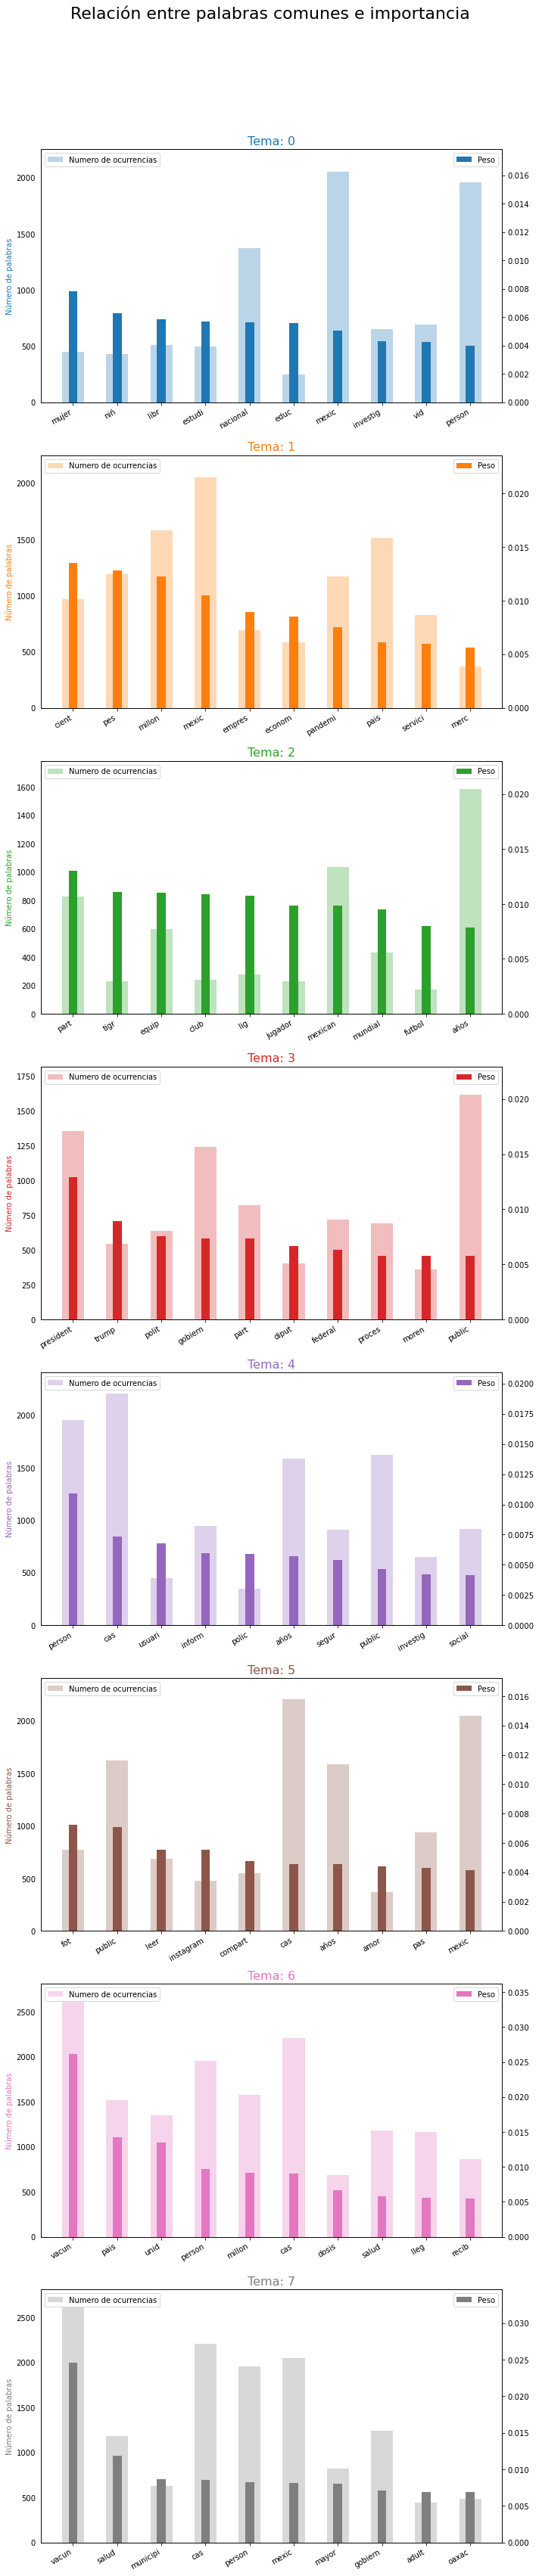

In [42]:
#hacemos un diccionario con el número de ocurrencias por palabra
topics = lda_model.show_topics(num_topics=num_of_topics,formatted=False)
data_flat = [w for w_list in CM for w in w_list]
counter = Counter(data_flat)

#encontramos para cada palabra en los temas cuantas veces aparece y su importancia
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['palabra', 'id_tema', 'importancia', 'num_ocurrencias'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(num_of_topics, 1, figsize=(10,int((num_of_topics+1)*5)))

#para cada tema le encuentro las palabras
for i, ax in enumerate(axes.flatten()):
    
    DF=df.loc[df["id_tema"]==i, :]
    
    ax.bar(x='palabra', height="num_ocurrencias", data=DF, color=cols[i], width=0.5, alpha=0.3, label='Numero de ocurrencias')
    ax_twin = ax.twinx()
    ax_twin.bar(x='palabra', height="importancia", data=DF, color=cols[i], width=0.2, label='Peso')
    
    ax.set_ylabel('Número de palabras', color=cols[i])
    
    max_weight=max(DF["importancia"])
    
    ax_twin.set_ylim(0, max_weight+0.01)
    
    
    max_amount_of_words=max(DF["num_ocurrencias"])
    
    ax.set_ylim(0, max_amount_of_words+200)
    
    
    ax.set_title('Tema: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df.loc[df["id_tema"]==i, 'palabra'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=1)    
fig.suptitle('Relación entre palabras comunes e importancia', fontsize=22, y=1.05)    
plt.show()


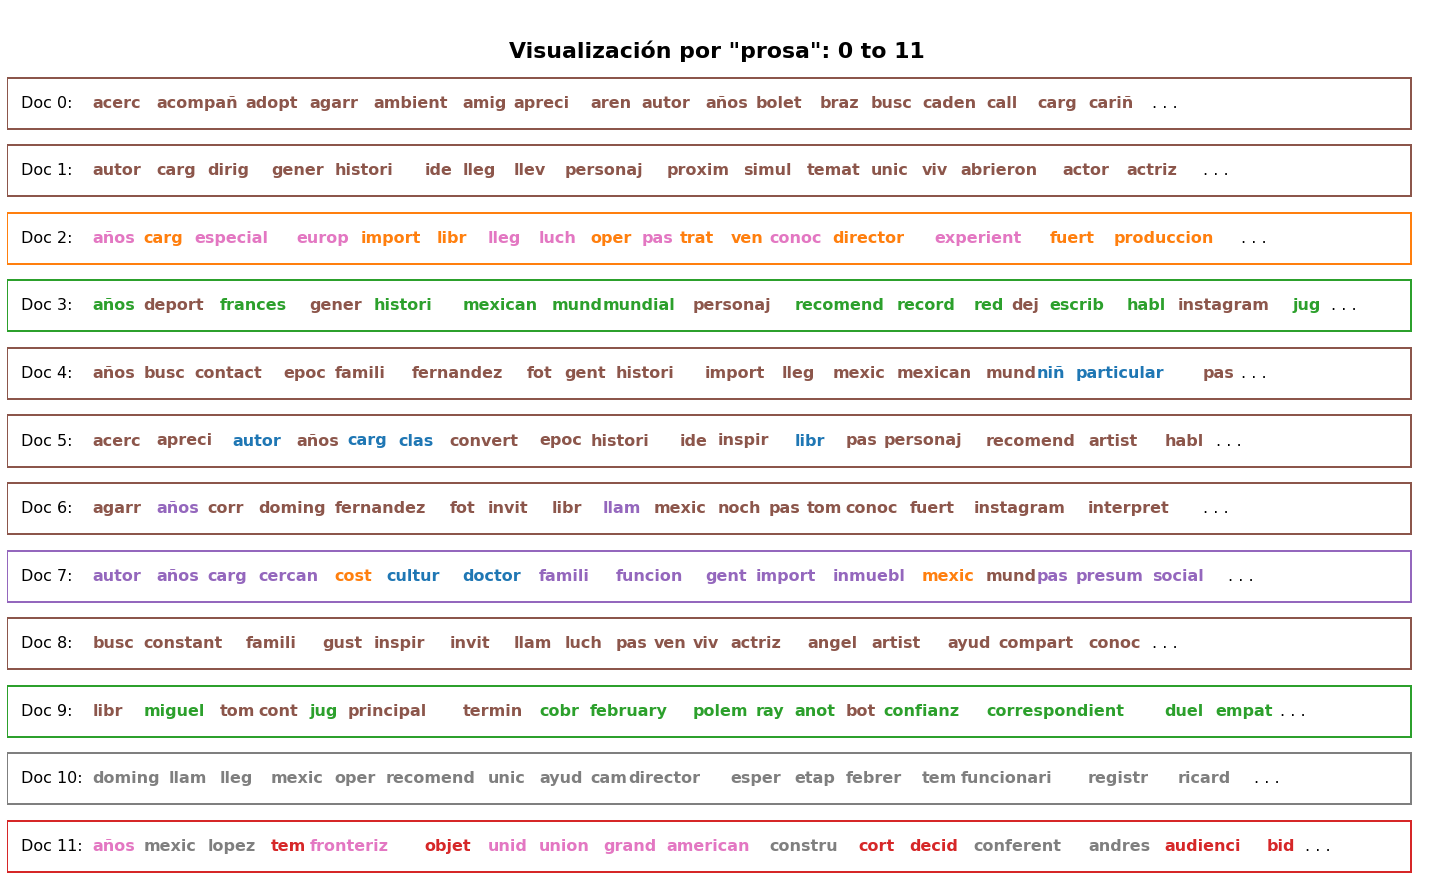

In [43]:
def sentences_chart(lda_model=lda_model, corpus=bow_corpus, start = 0, end = 13, mycolors=cols,num_of_topics=num_of_topics,num_of_words=17):
    corp = corpus[start:end] #palabras usadas

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95))       

    #para poner el título ponemos un espacio con un subplot en blanco
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            
            #corremos el corpus por el modelo
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            
            #encontramos el tema dominante para cada palabra
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            
            #leyenda que señala el número de doc
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',fontsize=16, color='black')

            # ordenamos para tomar el tema más relevante (el que tiene mayor peso)
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            
            #se dibuja el rectángulo con el color del tema más importante (la tupla de topics_percs_sorted
            #está de la forma (tema,importancia))
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))
            
            
            #agregamos cada palabra del color indicado en la posición indicada
            word_pos = 0.06
            for j, (word, topic) in enumerate(word_dominanttopic):
                #numero de palabras de output
                if j < num_of_words:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topic],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            
            #agregamos 3 puntitos para indicar que el texto sigue.
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Visualización por "prosa": ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [44]:
def black_box_plot(lda_model=lda_model,bow_corpus=bow_corpus):
    # Get topic weights
    topic_weights = []
    for i, row_list in enumerate(lda_model[bow_corpus]):
        topic_weights.append([w for i, w in row_list[0]])

    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Keep the well separated points (optional)
    arr = arr[np.amax(arr, axis=1) > 0.35]

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)

    # Plot the Topic Clusters using Bokeh
    output_notebook()
    n_topics = num_of_topics
    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
                  plot_width=900, plot_height=700)

    plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
    show(plot)
    
black_box_plot()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2466 samples in 0.011s...
[t-SNE] Computed neighbors for 2466 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2466
[t-SNE] Computed conditional probabilities for sample 2000 / 2466
[t-SNE] Computed conditional probabilities for sample 2466 / 2466
[t-SNE] Mean sigma: 0.000521
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.686428
[t-SNE] KL divergence after 1000 iterations: 0.450210


Loading BokehJS ...